# Learning objective

This notebook illustrates the meaning of the nonlinear Schr&ouml;dinger equation and its solution in the context of its derivation as the weakly nonlinear amplitude equation for harmonic wave propagation under the sine-Gordon equation.

# Preliminaries

In [1]:
# interactive plots setup
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

# sympy setup
import sympy as sp
sp.init_printing()
from sympy.vector import *

# ploting customizations
from matplotlib import pyplot as plt
size=16
params = {'legend.fontsize': 'large',
#          'figure.figsize': (20,8),
          'axes.labelsize': size,
          'axes.titlesize': size,
          'xtick.labelsize': size*0.875,
          'ytick.labelsize': size*0.875,
          'axes.titlepad': 25,
          'animation.embed_limit': 2**128}
plt.rcParams.update(params)
%matplotlib inline
from matplotlib import colormaps
# to fix up colorbars
import matplotlib.colors as colors
from mpl_toolkits.mplot3d import axes3d

# for animations
from matplotlib import animation, rc
from IPython.display import HTML

# numerics
import numpy as np
from scipy.integrate import solve_ivp
from scipy.fft import fft, fftfreq
from scipy.interpolate import griddata
from scipy import optimize

# to save plots as files and download them
#from google.colab import files

## Credit

Initial version written by [Ivan C. Christov](http://christov.tmnt-lab.org), Purdue University.

# NLS for sG

Starting from the dimensionless sine-Gordon equation, we derived the following dimensionless nonlinear Schr&ouml;dinger equation for the envelope of weakly nonlinear harmonic waves of wave number $k_0$:
$$
  i A_\tau = P A_{\xi\xi} + Q |A|^2A, \qquad \xi = \epsilon (x - \omega_0' t),\quad \tau = \epsilon^2 t,
$$
where
$$
  P = \frac{\omega_0''}{2},\quad Q = \frac{1}{4\omega_0},
$$
and the linear dispersion relation for sG gave us
$$
 \omega(k) = \sqrt{1+k^2},\quad \omega_0 = \omega(k_0), \quad \omega_0'' = \left. \frac{d^2\omega}{d k^2}\right|_{k=k_0} = \frac{1}{(1+k_0^2)^{3/2}},\quad
 \omega_0' = \left. \frac{d\omega}{d k}\right|_{k=k_0} = \frac{k_0}{\omega_0}.
$$

We'll solve this NLS eq. subject to periodic boundary conditions, consistent with the harmonic carrier wave, which was written as
$$
  \theta(x,t) = \epsilon u(x,t), \quad u(x,t) = A(\xi,\tau)e^{i(\omega_0 t - k_0 x)} + \mathrm{c.c}.
$$

In [2]:
# spatial interval
# using integer multiples of pi to make it easier to consider periodic IC
ximin = -11*np.pi
ximax = +11*np.pi

# number of grid points in discretization
N = 1000
# grid spacing
h = (ximax-ximin)/N
# the grid
xij = np.linspace(ximin,ximax,num=N,endpoint=False)
xj = np.linspace(5*ximin,5*ximax,num=N,endpoint=False)

# simualtion total run time
taumax = 30
tmax = 5*taumax

# Envelope soliton

An _envelope soliton_ solution of the form
$$
  A(\xi,\tau) = a(\xi - v_e \tau) e^{i\theta(\xi - v_p \tau)}
$$
for any given "envelope velocity" $v_e$ and "phase velocity" $v_p$ such that $2 v_p \ge v_e$. The quotes are to reminds are these are descriptive terms, not physical interpretations.

After a lot of work (see Chapter 3.2 of Dauxois &amp; Peyrard's book), one obtains
$$
  A(\xi,\tau) = A_0 \, \mathrm{sech}\left(\frac{\xi-\xi_0-v_e\tau}{\sqrt{2P/Q}/A_0}\right) e^{-i\big( (\xi - v_p \tau)v_e/2P - \varphi_0 \big)},
$$
where
$$
  A_0 = \sqrt{\frac{v_e^2 - 2v_e v_p}{2PQ}},
$$
where we must have $PQ>0$.

All the quantities with subscripts are **constant** parameters.

<u>Comments:</u>

*   $A_0e^{i\varphi_0}$ is the complex amplitude of the envelope soliton, so $A_0$ is the (real) magnitude of $|A|$, $\varphi_0\in[0,2\pi]$ is an arbitrary phase.
*   $v_e$ is the velocity of the peak of the envelope, which should also be real (but could be $>0$ or $<0$ $\Rightarrow$ right- or left-going soliton).
*   $v_p = v_e$ is not allowed!
*   The envelope's magnitude $A_0$ is a function of the velocities $v_e$, and $v_p$. Or, vice versa.
*   $\xi_0$ is the spatial shift of the peak, it is also real.

Let us eliminate $v_e$ in favor of $A_0$ and $v_p$. This would be nicer. After all, we know a nonlinear wave has a speed $v_e$ that is a function of its amplitude $A_0$ (and, for NLS, $v_p$). Then,
$$
  v_e = v_p \pm \sqrt{v_p^2 + 2PQA_0^2}.
$$
Let us take the "$+$" for definiteness, which is the right-going soliton.

In [3]:
# the linear dispersion relation
omega, k, kk = sp.symbols('omega k kk')

omega_of_k = sp.lambdify(k, sp.sqrt(1+k**2))
omega_prime_of_k = sp.lambdify(k, sp.sqrt(1+kk**2).diff(kk).subs(kk,k))
omega_double_prime_of_k = sp.lambdify(k, sp.sqrt(1+kk**2).diff(kk,kk).subs(kk,k))

k0 = 1

w0 = omega_of_k(k0)
w0p = omega_prime_of_k(k0)
w0pp = omega_double_prime_of_k(k0)

P = w0pp/2
Q = 1/(4*w0)

eps = 0.1

In [4]:
# the envelope soliton
def envelope_soliton(xi,tau,xi0,A0,vp,phi0):
  ve = vp + np.sqrt(vp**2 + 2*P*Q*A0**2)
  # to make the output periodic on [zmin,zmax]
  xi = xi + (ximax-ximin)/2
  arg = (xi-xi0-ve*tau)%(ximax-ximin)
  arg = (ximax-ximin)/2 - arg
  return A0/np.cosh(A0/np.sqrt(2*P/Q)*arg)*np.exp(-1j*((xi-vp*tau)*ve/(2*P)-phi0))

## Static plot

Let us visualize the solution with $v_p = 0$ and $\varphi_0=0$.

In [5]:
def plot_soli(x0,A0,t):
  ax = plt.gca()
  A = envelope_soliton(eps*(xj - w0p*t),eps**2*t,eps*x0,A0,0,0)
  u = A*np.exp(1j*(w0*t - k0*xj))
  ax.plot(xj, np.real(u), color='blue', lw=2, label='$u=$Re[$A e^{i(\omega_0t-k_0x)}$]')
  ax.plot(xj, np.abs(A), color='red', lw=2, label='$|A|$')
  ax.set_xlabel('$x$')
  ax.set_xlim(xj.min(),xj.max())
  ax.legend()
  plt.show()

interact(plot_soli, x0 = widgets.FloatSlider(value=0, min=-100, max=100, step=10),
                    A0 = widgets.FloatSlider(value=1, min=0.2, max=5, step=0.1),
                    t = widgets.FloatSlider(value=0, min=0, max=50, step=5) );

interactive(children=(FloatSlider(value=0.0, description='x0', min=-100.0, step=10.0), FloatSlider(value=1.0, …

## Animation

In [6]:
# define how to sample the solution in time
tnum = 100
dt = (tmax-0)/(tnum-1)
tspan = np.array(range(0,tnum))*dt

In [7]:
# set up the figure and axes
fig, ax = plt.subplots(figsize=(7.5,4.5))
ax.set_xlabel('$x$')
ax.set_xlim(xj.min(),xj.max())
ax.set_ylim(-1.1,1.1)
# nice dynamic label to show time
ttl = ax.text(0.05, 0.925, '', size='large',
              #bbox=dict(facecolor='none', edgecolor='black', boxstyle='round'),
              transform=ax.transAxes, animated=True)

# initialize plot objects with some dummy data (replaced in animation)
line1, = ax.plot(xj, 0*xj, color='blue', lw=2, label='$u=$Re[$A e^{i(\omega_0t-k_0x)}$]')
line2, = ax.plot(xj, 0*xj, color='red', lw=2, label='$|A|$')

# move legend out of the way
ax.legend(loc='upper left', bbox_to_anchor=(0.8, 1))

# so axes labels aren't cut off
plt.tight_layout()
plt.close()

# soliton parameters for animation
A0 = 1
x0 = 0#-75
vp = 0
phi = 0

# animation function called sequentially by `FuncAnimation' below
def animate(it):
  t = it*dt
  Aj = envelope_soliton(eps*(xj - w0p*t),eps**2*t,eps*x0,A0,vp,phi)
  uj = Aj*np.exp(1j*(w0*t - k0*xj))
  line1.set_data(xj, np.real(uj))
  line2.set_data(xj, np.abs(Aj))
  ttl.set_text(f'$t=${t:.2f}')

  return (line1, line2, ttl, )

framran = range(0,tnum)
anim = animation.FuncAnimation(fig, animate, frames=framran,
                               interval=100, blit=True)

# this is necessary to get the animation to work on Google's Colab
rc('animation', html='jshtml')
anim

Output hidden; open in https://colab.research.google.com to view.

In [8]:
print('carrier wave phase velocity is w0/k0 = ',w0/k0)
print('dispersive wave group velocity is cg = (dw/dk)|_k0 = ',w0p)
print('envelope soliton velocity is ve = ',vp + np.sqrt(vp**2 + 2*A0**2*P*Q))

carrier wave phase velocity is w0/k0 =  1.4142135623730951
dispersive wave group velocity is cg = (dw/dk)|_k0 =  0.7071067811865475
envelope soliton velocity is ve =  0.24999999999999997


# Comparison between NLS exact solution and sG simulatio

The sine-Gordon semi-discrete system with the proper weakly nonlinear scaling is:
$$
  \left. \begin{align} \dot{u}_j &= v_j,\\ \dot{v}_j &= \left(\frac{u_{j+1} - 2u_j + u_{j-1}}{h^2}\right) - \frac{1}{\epsilon}\sin (\epsilon u_j) \end{align}\right\}\quad j=0,\dots,N-1,
$$
subject to periodic BC.

In [9]:
# ODE system right-hand side
def sinegordon(t,u):
  F = np.empty(2*N)

  # boundary nodes require special care
  # by definition:
  F[0] = u[N]
  F[N-1] = u[2*N-1]
  # by periodic BCs:
  F[N] = (u[1] - 2*u[0] + u[N-1])/h**2 - 1/eps*np.sin(eps*u[0])
  F[2*N-1] = (u[0] - 2*u[N-1] + u[N-2])/h**2 - 1/eps*np.sin(eps*u[N-1])

  # interior nodes, per the ODE formula
  for j in range(1,N-1):
    F[j]   = u[j+N]
    F[j+N] = (u[j+1] - 2*u[j] + u[j-1])/h**2 - 1/eps*np.sin(eps*u[j])

  return F

Take the envelope soliton as the initial condition, computing $A_t$ using SympPy.

In [10]:
tt, epsilon, A_0 = sp.symbols('tt epsilon A_0', positive=True)
xx, PP, QQ, v_e, c_g = sp.symbols('xx PP QQ v_e c_g', real=True)

v_e = sp.sqrt(2*PP*QQ*A_0**2)
Asoli = A_0/sp.cosh(A_0/sp.sqrt(2*PP/QQ)*(epsilon*(xx-c_g*tt)-v_e*epsilon**2*tt)) \
        *sp.exp(-sp.I*(epsilon*(xx-c_g*tt)-v_e*epsilon**2*tt)*v_e/2)

In [11]:
#Aic = envelope_soliton(eps*(xj - w0p*0),eps**2*0,eps*x0,A0,0,0)
Asoli2 = sp.lambdify(xx, Asoli.subs(PP,P).subs({PP:P, QQ:Q, c_g:w0p, epsilon:eps, A_0:A0, tt:0}))
Atsoli2 = sp.lambdify(xx, Asoli.diff(tt).subs(PP,P).subs({PP:P, QQ:Q, c_g:w0p, epsilon:eps, A_0:A0, tt:0}))
Aic = Asoli2(xj-x0)
Atic = Atsoli2(xj-x0)
uic = Aic*np.exp(1j*(w0*0 - k0*xj))
uic = np.real_if_close(uic + np.conjugate(uic)) # chop off 0*1j
vic = Aic*1j*w0*np.exp(1j*(w0*0 - k0*xj)) + Atic*np.exp(1j*(w0*0 - k0*xj))
vic = np.real_if_close(vic + np.conjugate(vic))

In [12]:
# concatenate the two ICs as one vector to pass to solve_ivp
uvic = np.concatenate((uic,vic))

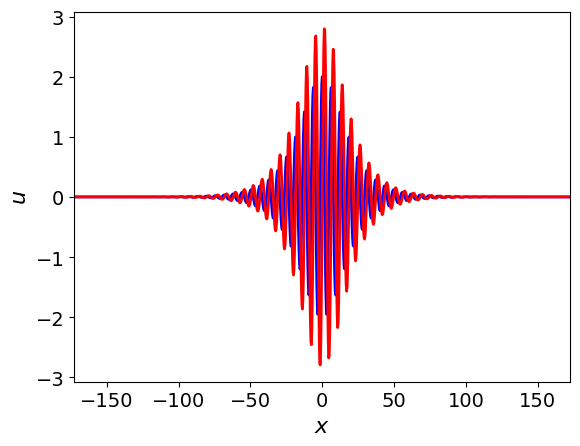

In [13]:

fig, ax = plt.subplots()
ax.plot(xj, uic, lw=2, color='blue')
ax.plot(xj, vic, lw=2, color='red')

ax.set_ylabel('$u$')
ax.set_xlim(xj.min(),xj.max())
ax.set_xlabel('$x$');

Simulate the system.

In [14]:
tol = 1e-6
sol = solve_ivp(fun=sinegordon,
                t_span=[0,tmax], y0=uvic,
                method='RK45', rtol=tol, atol=tol, dense_output=True)

First, just a quick static plot of the solution at `tplot`.

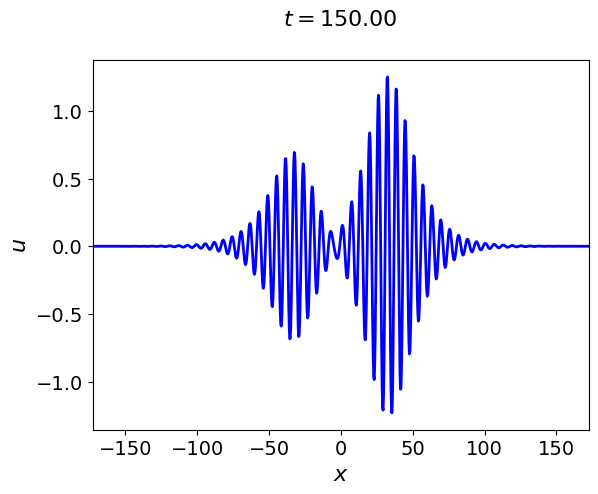

In [22]:
tplot = tmax
uj = sol.sol(tplot)

fig, ax = plt.subplots()
ax.plot(xj, uj[0:N], lw=2, color='blue')

ax.set_ylabel('$u$')
ax.set_xlim(xj.min(),xj.max())
ax.set_xlabel('$x$')
ax.set_title(f'$t=${tplot:.2f}');
#ax.legend();

## Animation

Next, we visualize our results using our snazzy animation tools.

In [16]:
# define how to sample the solution in time
tnum = 100
dt = (tmax-0)/(tnum-1)
tspan = np.array(range(0,tnum))*dt

In [17]:
# set up the figure and axes
fig, ax = plt.subplots(figsize=(7.5,4.5))
ax.set_xlabel('$x$')
ax.set_xlim(xj.min(),xj.max())
ax.set_ylim(-1.1,1.1)
# nice dynamic label to show time
ttl = ax.text(0.05, 0.925, '', size='large',
              #bbox=dict(facecolor='none', edgecolor='black', boxstyle='round'),
              transform=ax.transAxes, animated=True)
# so axes labels aren't cut off
plt.tight_layout()
plt.close()

# initialize plot objects with some dummy data (replaced in animation)
line1, = ax.plot(xj, 0*xj, color='blue', lw=2, label='$u=$Re[$A e^{i(\omega_0t-k_0x)}$]')
line2, = ax.plot(xj, 0*xj, color='red', lw=2, label='$|A|$ from NLS solution')
line3, = ax.plot(xj, 0*xj, color='black', lw=1, ls='dashed', label='sG simulation')

# move legend out of the way
ax.legend(loc='upper left', bbox_to_anchor=(0.8, 1))

# animation function called sequentially by `FuncAnimation' below
def animate(it):
  t = it*dt
  Aj = envelope_soliton(eps*(xj - w0p*t),eps**2*t,eps*x0,A0,vp,phi)
  uj = Aj*np.exp(1j*(w0*t - k0*xj))
  sg = sol.sol(t)[0:N]
  line1.set_data(xj, np.real(uj))
  line2.set_data(xj, np.abs(Aj))
  line3.set_data(xj, sg)
  ttl.set_text(f'$t=${t:.2f}')

  return (line1, line2, line3, ttl, )

framran = range(0,tnum)
anim = animation.FuncAnimation(fig, animate, frames=framran,
                               interval=100, blit=True)

# this is necessary to get the animation to work on Google's Colab
rc('animation', html='jshtml')
anim

Output hidden; open in https://colab.research.google.com to view.

## Space-time plot

In [18]:
# define how to sample the solution in time
tnum = 200
dt = (tmax-0)/(tnum-1)
tspan = np.array(range(0,tnum))*dt

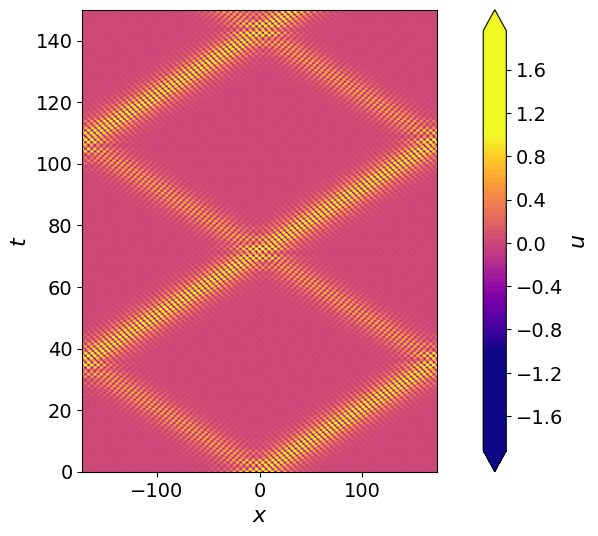

In [19]:
# make a matrix of space-time values u(x,t)
ujp = np.empty((tnum,N))
for it in range(0,tnum):
  ujp[it,:] = sol.sol(it*dt)[0:N]

# might also consider divergent colormaps
fig, ax = plt.subplots(figsize=(12, 6))
plt.contourf(xj, tspan, ujp, 100, cmap='plasma',
             vmin=-1, vmax=1, norm=colors.CenteredNorm(), extend='both')
plt.colorbar(label='$u$')
ax.set_ylim(0,tmax)
ax.set_ylabel('$t$')
ax.set_xlim(xj.min(),xj.max())
ax.set_xlabel('$x$')
ax.set_aspect(3/1)